In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the YOLOv8 segmentation model
model = YOLO('yolo11l-seg.pt')

In [2]:
def compute_saliency(image):
    results = model.predict(image, conf=0.3)
    masks = results[0].masks
    if masks is not None:
        mask0 = masks[0].data.cpu().numpy().squeeze()
        saliency_map = np.zeros(mask0.shape, np.float32)
        for mask in masks:
            mask = mask.data.cpu().numpy()
            saliency_map+=mask.squeeze()

        saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
        saliency_map = cv2.resize(saliency_map, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_NEAREST)
    else:
        saliency_map = np.zeros((image.shape[0],image.shape[1]), np.float32)
    return saliency_map

def compute_energy(image):
    b, g, r = cv2.split(image)
    b_energy = np.abs(cv2.Scharr(b, -1, 1, 0)) + np.absolute(cv2.Scharr(b, -1, 0, 1))
    g_energy = np.abs(cv2.Scharr(g, -1, 1, 0)) + np.absolute(cv2.Scharr(g, -1, 0, 1))
    r_energy = np.abs(cv2.Scharr(r, -1, 1, 0)) + np.absolute(cv2.Scharr(r, -1, 0, 1))
    energy_map = b_energy + g_energy + r_energy
    energy_map = (energy_map - energy_map.min()) / (energy_map.max() - energy_map.min())
    return energy_map

def find_vertical_seam(energy_map):
    height, width = energy_map.shape
    dp = energy_map.copy()
    backtrack = np.zeros_like(dp, dtype=np.int32)

    for i in range(1, height):
        left = dp[i-1, :-2]
        middle = dp[i-1, 1:-1]
        right = dp[i-1, 2:]

        # Calculate minimum energies for middle columns
        dp[i, 1:-1] += np.minimum(np.minimum(left, middle), right)

        # Update backtrack for middle columns
        min_indices = np.argmin(np.stack([left, middle, right], axis=0), axis=0)
        backtrack[i, 1:-1] = min_indices + (min_indices - 1)

        # Handle the leftmost pixel
        dp[i, 0] += min(dp[i-1, 0], dp[i-1, 1])
        backtrack[i, 0] = np.argmin(dp[i-1, :2])

        # Handle the rightmost pixel
        dp[i, -1] += min(dp[i-1, -2], dp[i-1, -1])
        backtrack[i, -1] = np.argmin(dp[i-1, -2:]) - 1 + (width - 2)

    # Trace back to find the vertical seam
    seam = []
    j = np.argmin(dp[-1])
    for i in range(height - 1, -1, -1):
        seam.append((i, j))
        j = np.clip(j + backtrack[i, j], 0, width - 1)  # Ensure j stays within bounds

    return seam[::-1]

def remove_vertical_seam(image, seam):
    height, width, channels = image.shape
    output = np.zeros((height, width - 1, channels), dtype=image.dtype)

    for i, (row, col) in enumerate(seam):
        output[row, :col] = image[row, :col]
        output[row, col:] = image[row, col+1:]

    return output

def seam_carving(image, energy_map, num_seams):
    for _ in range(num_seams):
        seam = find_vertical_seam(energy_map)
        image = remove_vertical_seam(image, seam)
        energy_map = remove_vertical_seam(energy_map[:, :, np.newaxis], seam)[:, :, 0]
    
    return image

In [17]:
image = cv2.imread('images/ (3).jpg')
height, width = image.shape[:2]
if height > width:
    ratio = 700 / width
else:
    ratio = 700 / height

new_dimensions = (int(width * ratio), int(height * ratio))
image = cv2.resize(image, new_dimensions)
print(image.shape)

(700, 918, 3)


In [11]:
"""
saliency_map = compute_energy(image)
I_resized = seam_carving(image,saliency_map, 400)

# Affichage des images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map)
plt.title('Saliency map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(I_resized, cv2.COLOR_BGR2RGB))
plt.title('Image Redimensionnée')
plt.axis('off')

plt.show()
"""

"\nsaliency_map = compute_energy(image)\nI_resized = seam_carving(image,saliency_map, 400)\n\n# Affichage des images\nplt.figure(figsize=(10, 5))\nplt.subplot(1, 3, 1)\nplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\nplt.title('Image Originale')\nplt.axis('off')\n\nplt.subplot(1, 3, 2)\nplt.imshow(saliency_map)\nplt.title('Saliency map')\nplt.axis('off')\n\nplt.subplot(1, 3, 3)\nplt.imshow(cv2.cvtColor(I_resized, cv2.COLOR_BGR2RGB))\nplt.title('Image Redimensionnée')\nplt.axis('off')\n\nplt.show()\n"


0: 640x384 1 cat, 55.4ms
Speed: 2.0ms preprocess, 55.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


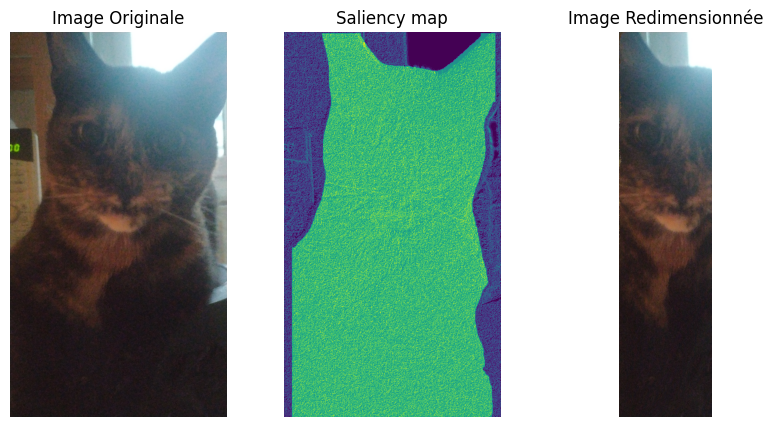

In [12]:
saliency_map = compute_saliency(image) + compute_energy(image)
I_resized = seam_carving(image,saliency_map, 400)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map)
plt.title('Saliency map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(I_resized, cv2.COLOR_BGR2RGB))
plt.title('Image Redimensionnée')
plt.axis('off')

plt.show()

In [6]:
saliency_map = compute_saliency(image) + compute_energy(image)
I_resized = seam_carving(image,saliency_map, 400)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map)
plt.title('Saliency map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(I_resized, cv2.COLOR_BGR2RGB))
plt.title('Image Redimensionnée')
plt.axis('off')

plt.show()


0: 640x384 1 cat, 444.6ms
Speed: 298.6ms preprocess, 444.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)



0: 640x384 1 cat, 444.8ms
Speed: 293.9ms preprocess, 444.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 96x640 1 cat, 366.2ms
Speed: 287.0ms preprocess, 366.2ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 640)


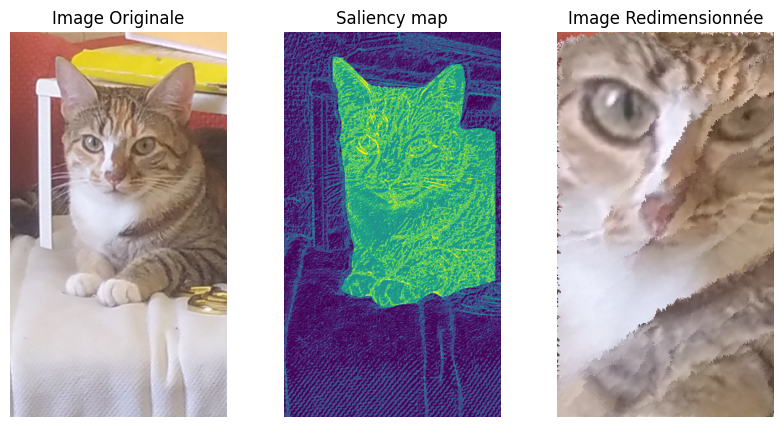

In [7]:
from datetime import datetime

saliency_map = compute_saliency(image) + compute_energy(image)
I_resized = seam_carving(image,saliency_map, int(3*image.shape[1]/4))
I_resized2 = cv2.transpose(I_resized)
saliency_map2 = compute_saliency(I_resized2) + compute_energy(I_resized2)
I_resized2 = cv2.transpose(seam_carving(I_resized2,saliency_map2, int(3*image.shape[0]/4)))

now = datetime.now()
filename = now.strftime("%Y-%m-%d_%H-%M-%S.jpg")
cv2.imwrite(filename, I_resized2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map)
plt.title('Saliency map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(I_resized2, cv2.COLOR_BGR2RGB))
plt.title('Image Redimensionnée')
plt.axis('off')

plt.show()